In [3]:
!pip -q install mutagen
!pip -q install jsbeautifier
from mutagen.mp3 import MP3
import jsbeautifier as jsb
import requests
import os
from IPython.display import clear_output

     |████████████████████████████████| 225kB 4.4MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [15]:
!pip -q install wget
!pip -q install music-tag
import string
import json
import wget
from PIL import Image as image
import music_tag as mt
# This Functions can be used individually
def music_search(term, API_KEY):
  if (term=='skip'):
    return 'skip'
  url = "https://shazam.p.rapidapi.com/search"
  querystring = {"term":term,"locale":"en-US"}
  headers = {
      'x-rapidapi-key': API_KEY,
      'x-rapidapi-host': "shazam.p.rapidapi.com"
      }
  response=(requests.request("GET", url, headers=headers, params=querystring)).json()
  if (len(response)==0):
    print("The song term not found.\n")
    return music_search(input("Search for another term: "), API_KEY)
  else:
    return response

def music_list(file, mode, api):
  remove=['VIDEO','Video','video','lyrics','lyric','Lyrics','Lyric','LYRICS','.mp3','!','@','#','$','%','^','&','*','(',')','+','=','~','`',':','"',',','/','?','}','{','|']
  for i in remove:
    file = file.replace(i,'')
  file = file.replace('_-_',' ').replace("_",' ')
  music=''
  music = music_search(file, api)
  if list(music.keys())[0] == 'message':
    print(music['message'])
    return -1
  if (music=='skip'):
    return 'skip'
  if (mode==0):
    option = '0'
  if (mode==1):
    for i in range(0,len(music['tracks']['hits'])):
      print(i,' ',music['tracks']['hits'][i]['track']['key'],' ',music['tracks']['hits'][i]['track']['share']['subject'])
    option = input("Enter the option(number/(S)earch): ")
  if (option=='S' or option=='s'):
    term=input("Search for another term: ")
    if (term=='skip'):
      return 'skip'
    else:
      return music_list(term, mode, api)
  if (option.isdigit()):
    return music['tracks']['hits'][int(option)]['track']['key']

  
  

def Meta_Retrieve(key, file, API_KEY):
  url = "https://shazam.p.rapidapi.com/songs/get-details"
  querystring = {"key":key,"locale":"en-US"}
  headers = {
      'x-rapidapi-key': API_KEY,
      'x-rapidapi-host': "shazam.p.rapidapi.com"
      }
  details = requests.request("GET", url, headers=headers, params=querystring)
  meta=details.json()
  meta['share']['subject'] = (meta['share']['subject']).replace('\'','')
  Image = wget.download(meta['images']['coverarthq'],out=meta['share']['subject']+'.jpg')
  clear_output()
  thumb = image.open(Image)
  display(thumb.resize((70, 70)))
  print("FileName:",file)
  tag={}
  try:
    tag["TrackTitle"] = string.capwords(meta['title'])
    print('Title:', tag["TrackTitle"])
  except:
    temp = ''
    while (len(temp) == 0):
      tag["TrackTitle"] = string.capwords(input("Enter the Title manually: "))
      temp = tag["TrackTitle"]
    print('Title:', tag["TrackTitle"])
  try:
    tag["Artist"] = string.capwords((meta['subtitle']).replace('Feat.','and'))
    print('Artist:', tag["Artist"])
  except:
    temp = ''
    while (len(temp) == 0):
      tag["Artist"] = string.capwords(input("Enter the Artist manually: "))
      temp = tag["Artist"]
    print('Artist:', tag["Artist"])
  try:
    if (str(meta['sections'][0]['metadata'][0]['title']) != 'Album'):
      raise Exception
    tag["Album"] = string.capwords(meta['sections'][0]['metadata'][0]['text'])
    print('Album:', tag["Album"])
  except:
    temp = ''
    while (len(temp) == 0):
      tag["Album"] = string.capwords(input("Enter the Album manually: "))
      temp = tag["Album"]
    print('Album:', tag["Album"])
  try:
    if (str(meta['sections'][0]['metadata'][1]['title']) != 'Label'):
      raise Exception
    tag["Comment"] = string.capwords(meta['sections'][0]['metadata'][1]['text'])
    print('Label:', tag["Comment"])
  except:
    temp = ''
    while (len(temp) == 0):
      tag["Comment"] = string.capwords(input("Enter the Label manually: "))
      temp = tag["Comment"]
    print('Label:', tag["Comment"])
  try:
    if (str(meta['sections'][0]['metadata'][2]['title']) != 'Released'):
      raise Exception
    tag["Year"] = string.capwords(meta['sections'][0]['metadata'][2]['text'])
    print('Year:', tag["Year"])
  except:
    temp = ''
    while (temp.isdigit() == False):
      tag["Year"] = string.capwords(input("Enter the year manually: "))
      temp = tag["Year"]
    print('Year:', tag["Year"])
  try:
    tag["Genre"] = string.capwords(meta['genres']['primary'])
    print('Genre:', tag["Genre"])
  except:
    temp = ''
    while (len(temp) == 0):
      tag["Genre"] = string.capwords(input("Enter the Genre manually: "))
      temp = tag["Genre"]
    print('Genre:', tag["Genre"])
  try:
    if (str(meta['sections'][1]['type']) != 'LYRICS'):
      raise Exception
    tag["Lyrics"] = meta['sections'][1]['text']
    print('Lyrics:', tag["Lyrics"])
  except:
    flag = 1
    while (flag == 1):
      try:
        with open(input("Save the lyrics in a file and then Enter the File name: ")) as lyric_file:
          tag["Lyrics"] = [line.rstrip() for line in lyric_file]
        flag = 0
      except IOError:
        pass
    print('Lyrics:', tag["Lyrics"])
  return tag, Image

def Tags_Save(Tags, Image, file_path):
  import shutil
  !mid3v2 -p '{Image}' '{file_path}'
  f = mt.load_file(file_path)
  if type(Tags['Lyrics']) == list:
    a = ''
    for i in Tags['Lyrics']:
      a = a + i + '\n'
    Tags['Lyrics'] = a
  for i in Tags.keys():
    f[i] = Tags[i]
  print("Renamed",file_path,"--> ",os.path.split(file_path)[0]+'/'+Tags['TrackTitle']+'-'+Tags['Artist']+'.mp3')
  os.remove(Image)
  print("Tags saved successfully")
  try:
    shutil.move(os.path.split(file_path)[0]+'/Lyrics/'+(os.path.split(file_path)[1]).replace('.mp3','.lrc'), os.path.split(file_path)[0]+'/Lyrics/'+Tags['TrackTitle']+' - '+Tags['Artist']+'.lrc')
    print("Synced Lyrics saved successfully")
  except:
    print("Synced Lyrics not Found")
  input("Enter to Continue")
  f.save()
  shutil.move(file_path, os.path.split(file_path)[0]+'/'+Tags['TrackTitle']+' - '+Tags['Artist']+'.mp3')

# Synced Lyrics
from bs4 import BeautifulSoup
def synced_lyric(file_path, term):
  clear_output()
  audio = MP3(file_path)
  audio_info = audio.info    
  seconds = int(audio_info.length)
  print(os.path.split(file_path)[1],'[',seconds//3600,':',seconds//60,':',seconds%60,']')
  url = "https://www.megalobiz.com/search/all?qry="+term.replace(' - ',' ').replace('.mp3','').replace(' ','+')+"&searchButton.x=0&searchButton.y=0"
  response=requests.request("GET", url)
  soup = BeautifulSoup(response.text, 'lxml')
  lyric_list = soup.find_all('a', class_="entity_name")
  print("\nThe Following Results were found: ")
  try:
    for i in range(0,len(lyric_list)):
      print(i,')',lyric_list[i]["title"])
  except:
    print("No Results found!!")
  i = input("Enter the selection(Number/(S)earch/skip): ")
  if (i=='S' or i=='s'):
    return synced_lyric(file_path, input("Enter the Search Term: "))
  if (i=='skip'):
    return 'skip'
  i = int(i)
  url = "https://www.megalobiz.com"+lyric_list[i]["href"]
  response=requests.request("GET", url)
  if(len(str(soup.find('div',class_='lyrics_details entity_more_info')))>0):
    soup = BeautifulSoup(response.text, 'lxml')
    clear_output()
    print(str(soup.find('div',class_='lyrics_details entity_more_info')).replace('</span>','').replace('<br/>','').replace('<div class="lyrics_details entity_more_info" id="'+'lrc_'+lyric_list[i]['href'][len(lyric_list[i]['href'])-8:]+'_details">','').replace('<span id="'+'lrc_'+lyric_list[i]['href'][len(lyric_list[i]['href'])-8:]+'_lyrics">','').replace('</div>',''))
    input("Enter to Continue")
    if (os.path.isdir(os.path.split(file_path)[0]+'/Lyrics/')==False):
      os.mkdir(os.path.split(file_path)[0]+'/Lyrics/')
    with open(os.path.split(file_path)[0]+'/Lyrics/'+os.path.split(file_path)[1].replace('mp3','lrc'), 'w') as f:
      print(str(soup.find('div',class_='lyrics_details entity_more_info')).replace('</span>','').replace('<br/>','').replace('<div class="lyrics_details entity_more_info" id="'+'lrc_'+lyric_list[i]['href'][len(lyric_list[i]['href'])-8:]+'_details">','').replace('<span id="'+'lrc_'+lyric_list[i]['href'][len(lyric_list[i]['href'])-8:]+'_lyrics">','').replace('</div>',''), file=f)
    print(os.path.split(file_path)[1].replace('.mp3','.lrc')," Lyric file saved")
    return 'Done'
  else:
    print("No Lyrics found")
  clear_output()

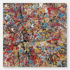

FileName: Ed Sheeran - Afterglow [Official Performance Video].mp3
Title: Afterglow
Artist: Ed Sheeran
Album: Afterglow - Single
Enter the Label manually: Asylum
Label: Asylum
Enter the year manually: 2020
Year: 2020
Genre: Pop
Lyrics: ['One, two', '', "Stop the clocks, it's amazing", 'You should see the way the light dances off your hair', 'A million colours of hazel, golden and red', 'Saturday morning is fading', "The Sun's reflected by the coffee in your hand", 'My eyes are caught in your gaze all over again', '', 'We were love drunk waiting on a miracle', 'Trying to find ourselves in the winter snow', 'So alone in love like the world had disappeared', "Oh, I won't be silent and I won't let go", 'I will hold on tighter till the afterglow', "And we'll burn so bright till the darkness softly clears", '', 'Oh, I will hold on to the afterglow', 'Oh, I will hold on to the afterglow', '', "The weather outside's changing", 'The leaves are buried under six inches of white', 'The radio is pla

In [16]:
# Music Tagger
from IPython.display import clear_output
import os
option = ''
#Get API Key by signing up in this link: 'https://rapidapi.com/apidojo/api/shazam?endpoint=apiendpoint_e5620280-234d-409b-a0cf-eb618f1f687d'
API_KEY = "" #Enter you API Key
while (len(API_KEY) == 0):
  API_KEY = input("Enter the API Key by signing up in this link: 'https://rapidapi.com/apidojo/api/shazam?endpoint=apiendpoint_e5620280-234d-409b-a0cf-eb618f1f687d':")
try:
  while ( option != '0' and option != '1' ):
    clear_output()
    option = input("Auto Music Tagger\n0). Tag MP3 Files:\n1). Tag all MP3's in a Directory\nEnter your option: ")
    if (option == '0'):
      file_path = []
      path = ''
      while (path != 'exit'):
        path = input("Enter the file location eg. a/b/c/abc.mp3 (type exit to stop): ")
        file_path.append(path)
      file_path.remove('exit')
      mode = int(input("Enter the mode(0/1) (0:Auto selects probable options) (1:mannual selection (preferred)): "))
      for file in file_path:
        if (file.endswith(('.mp3','.mp3\'')) and len(mt.load_file(os.path.join(os.path.split(file)[0], file))['comment'])!=0):
          print(file," is already tagged")
          input("Enter to Continue")
          continue
        if (file.endswith(('.mp3','.mp3\'')) and len(mt.load_file(os.path.join(os.path.split(file)[0], file))['comment'])==0):
          clear_output()
          print(os.path.split(file)[1])
          # For selecting the song
          key = music_list(os.path.split(file)[1], mode, API_KEY)
          if (key == -1):
            break
          if (key == 'skip'):
            clear_output()
            continue
          # To get the Synced Lyrics
          synced_lyric(file, os.path.split(file)[1])
          # To get the Meta data of the selected song
          Tags, Image = Meta_Retrieve(key, os.path.split(file)[1], API_KEY)
          # to save the tags
          Tags_Save(Tags, Image, file)

    elif (option == '1'):
      file_path = input("Enter the folder location eg. a/b/c/: ")
      if (file_path.endswith('/')==False):
        file_path = file_path + '/'
      mode = int(input("Enter the mode(0/1) (0:Auto selects probable options) (1:mannual selection (preferred)): "))
      for subdir, dirs, files in os.walk(file_path):
        for file in files:
          if (file.endswith(('.mp3','.mp3\'')) and len(mt.load_file(os.path.join(file_path, file))['comment'])!=0):
            print(file," is already tagged")
            input("Enter to Continue")
            continue
          if (file.endswith(('.mp3','.mp3\'')) and len(mt.load_file(os.path.join(file_path, file))['comment'])==0):
            clear_output()
            print(file)
            # For selecting the song
            key = music_list(file, mode, API_KEY)
            if (key == -1):
              break
            if (key == 'skip'):
              clear_output()
              continue
            # To get the Synced Lyrics
            synced_lyric(os.path.join(file_path, file), file)
            # To get the Meta data of the selected song
            Tags, Image = Meta_Retrieve(key, file, API_KEY)
            # to save the tags
            Tags_Save(Tags, Image, os.path.join(file_path, file))

    else:
      print("Check your options\n")


except (KeyboardInterrupt):
  clear_output()
  print("Auto Music Tagger Shutdown")